# Линейные модели, SVM и деревья решений.

In [21]:
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.svm import SVC
import graphviz

from IPython.display import Image
from warnings import simplefilter
simplefilter('ignore')

In [2]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('credit_train_preprocess.csv', encoding='cp1251', sep=',')

In [3]:
# смотрим на первые пять строк
data.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,34.0,59998.00,10,1.6,0.461599,30000.0,1.0,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,34.0,10889.00,6,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,32.0,10728.00,12,1.1,0.461599,35000.0,5.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,27.0,12009.09,12,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,45.0,21229.00,10,1.1,0.421385,35000.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0


## 1) Корреляционный анализ

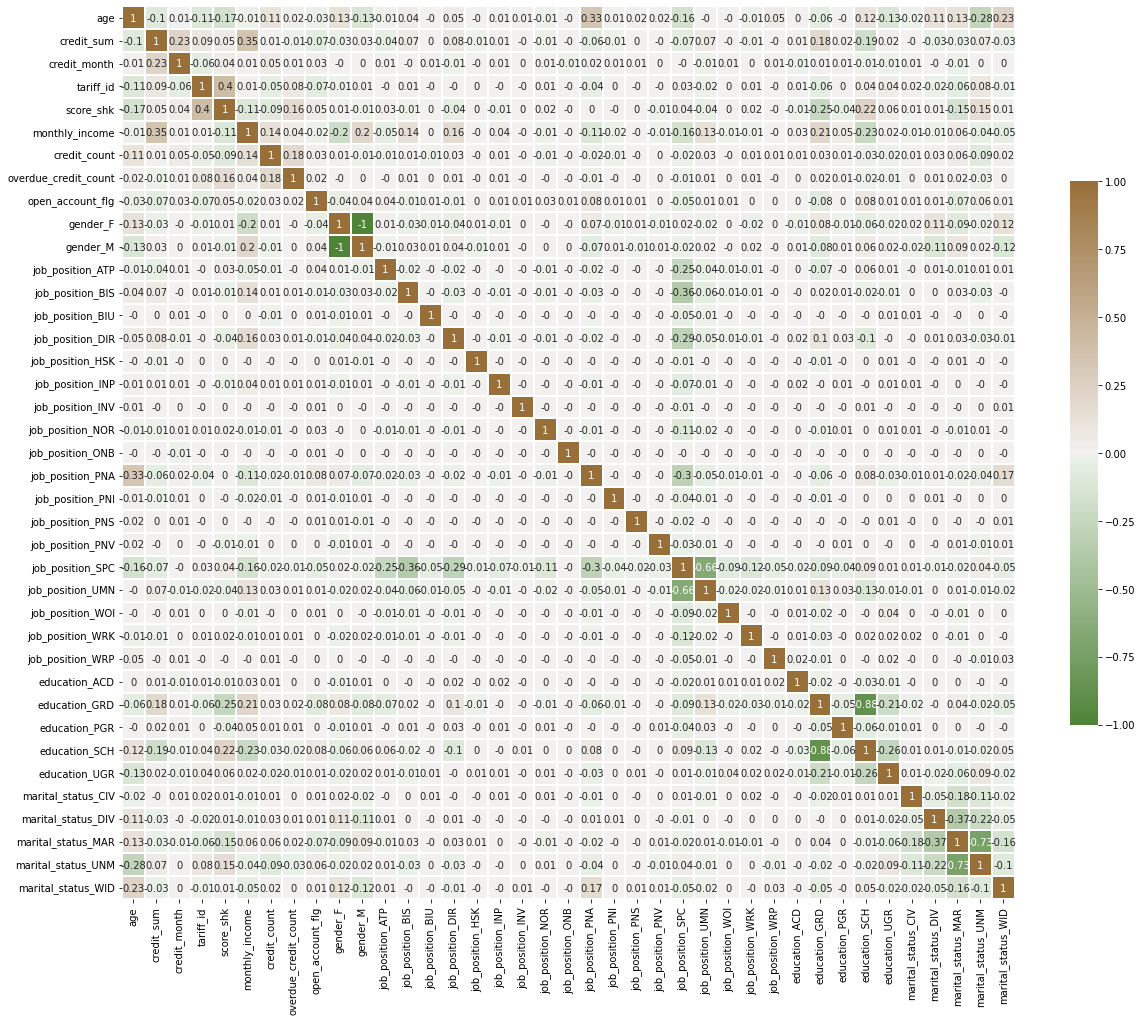

In [4]:
corr = data.corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(120, 50, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

In [5]:
print('Признаки, имеющие максимальную по модулю корреляцию с целевым признаком')
best_params = data.corr()['open_account_flg'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.02]
best_params

Признаки, имеющие максимальную по модулю корреляцию с целевым признаком


education_GRD         0.082371
education_SCH         0.078337
job_position_PNA      0.076889
credit_sum            0.072039
tariff_id             0.067346
marital_status_MAR    0.067112
marital_status_UNM    0.061312
job_position_SPC      0.049143
score_shk             0.048686
gender_F              0.044265
gender_M              0.044265
job_position_ATP      0.038288
credit_count          0.032374
age                   0.031062
job_position_NOR      0.027320
credit_month          0.025809
monthly_income        0.023697
Name: open_account_flg, dtype: float64

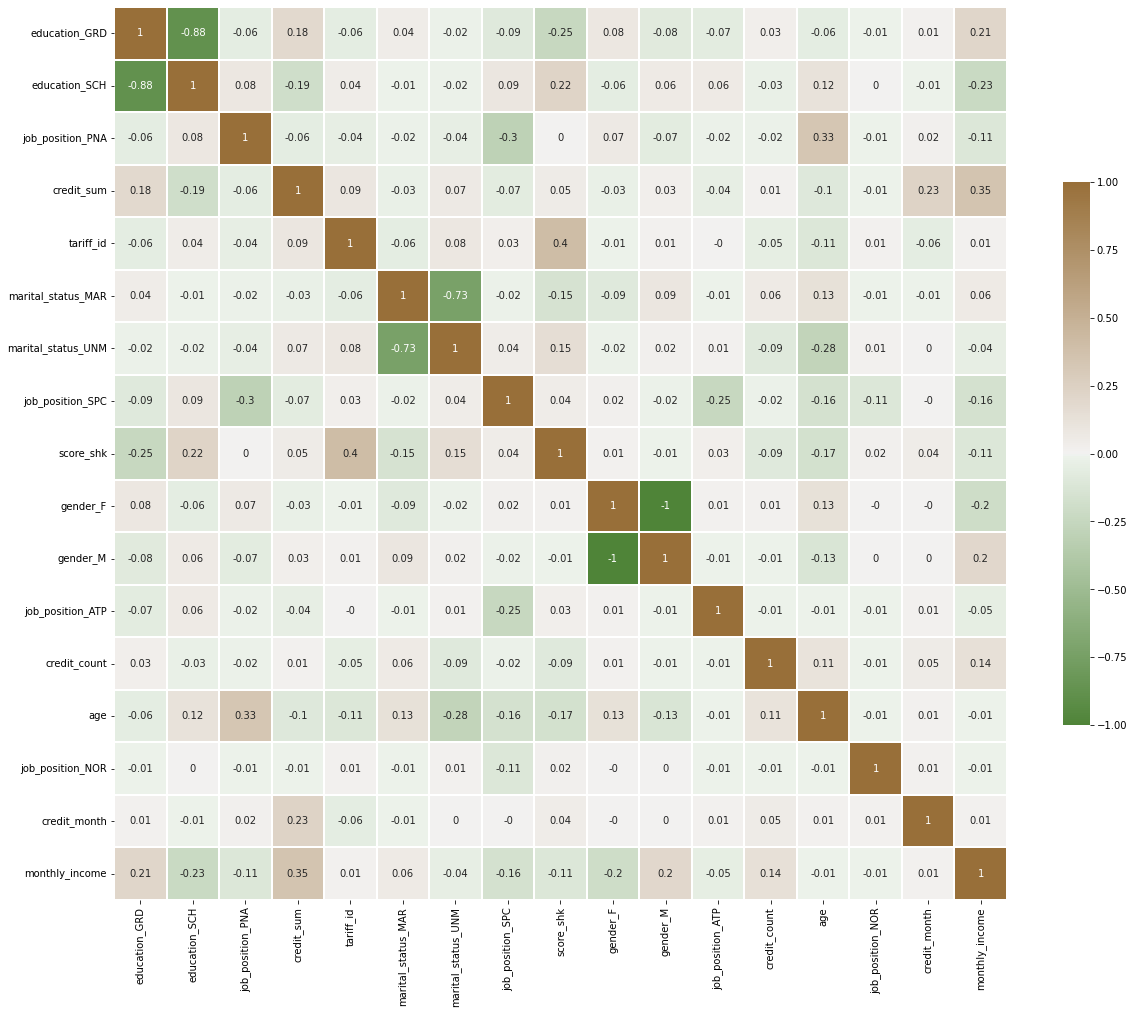

In [6]:
corr = data[best_params.index].corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(120, 50, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

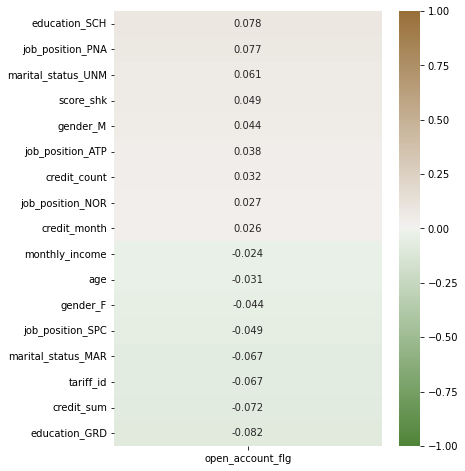

In [7]:
plt.figure(figsize=(6, 8))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'open_account_flg')].corr()['open_account_flg'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap=cmap, annot=True)
plt.show()

## 2) Разделение выборки на обучающую и тестовую

In [8]:
data_best = data[best_params.index]
data_best.head()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
0,1,0,0,59998.00,1.6,1,0,0,0.461599,0,1,0,1.0,34.0,0,10,30000.0
1,0,1,0,10889.00,1.1,1,0,0,0.461599,1,0,0,2.0,34.0,0,6,35000.0
2,0,1,0,10728.00,1.1,1,0,1,0.461599,0,1,0,5.0,32.0,0,12,35000.0
3,0,1,0,12009.09,1.1,1,0,1,0.461599,1,0,0,2.0,27.0,0,12,35000.0
4,0,1,0,21229.00,1.1,1,0,1,0.421385,0,1,0,1.0,45.0,0,10,35000.0


In [9]:
y = data['open_account_flg']
#X = data.drop('open_account_flg', axis=1)
X = data_best
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=21)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=21)

## 3) Масштабирование данных

In [10]:
scaler = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train.describe()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
count,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000
mean,0.425000,0.514759,0.023561,0.117340,0.345539,0.549665,0.304518,0.787651,0.404031,0.521452,0.478548,0.015663,0.117555,0.348769,0.003648,0.242378,0.062588
std,0.494351,0.499790,0.151679,0.082275,0.252486,0.497536,0.460211,0.408978,0.129396,0.499548,0.499548,0.124169,0.096737,0.198402,0.060289,0.108435,0.044938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.060249,0.106383,0.000000,0.000000,1.000000,0.310565,0.000000,0.000000,0.000000,0.055556,0.188679,0.000000,0.212121,0.034926
50%,0.000000,1.000000,0.000000,0.092536,0.340426,1.000000,0.000000,1.000000,0.396125,1.000000,0.000000,0.000000,0.111111,0.301887,0.000000,0.212121,0.053309
75%,1.000000,1.000000,0.000000,0.148270,0.638298,1.000000,1.000000,1.000000,0.490279,1.000000,1.000000,0.000000,0.166667,0.471698,0.000000,0.272727,0.080882
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4)  Логистическая регрессия

In [11]:
# обучаем логистическую регрессию
clf = LogisticRegression()
clf.fit(x_train, y_train);

In [12]:
#считаем точность (долю правильных ответов) на тестовой выборке
clf.score(x_test, y_test)

0.8191472747149774

In [13]:
def print_metrics(y_test, y_pred):
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F1-measure: {f1_score(y_test, y_pred)}")

In [14]:
# вычисляем метрики точности
y_pred_log = clf.predict(x_test)
print_metrics(y_test, y_pred_log)

Precision: 0.5862068965517241
F1-measure: 0.01446808510638298


## 5) SVC

In [15]:
best_svm_model = SVC()
best_svm_model.fit(x_train, y_train)
y_pred_svm = best_svm_model.predict(x_test)
print_metrics(y_test, y_pred_svm)

Precision: 0.5714285714285714
F1-measure: 0.003436426116838488


## 6) Дерево решений

In [16]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeClassifier(random_state=3) #max_depth=5
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
#tree.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 29}


In [17]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

Precision: 0.4374255065554231
F1-measure: 0.23227848101265824


In [18]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

tariff_id: 0.203
credit_sum: 0.191
score_shk: 0.169
age: 0.11
credit_month: 0.102
monthly_income: 0.058
credit_count: 0.045
job_position_PNA: 0.03
education_SCH: 0.027
marital_status_MAR: 0.017
gender_F: 0.012
gender_M: 0.012
job_position_SPC: 0.01
marital_status_UNM: 0.009
education_GRD: 0.005
job_position_ATP: 0.0
job_position_NOR: 0.0


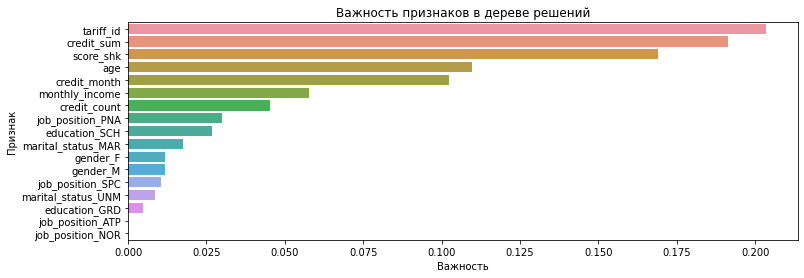

In [19]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

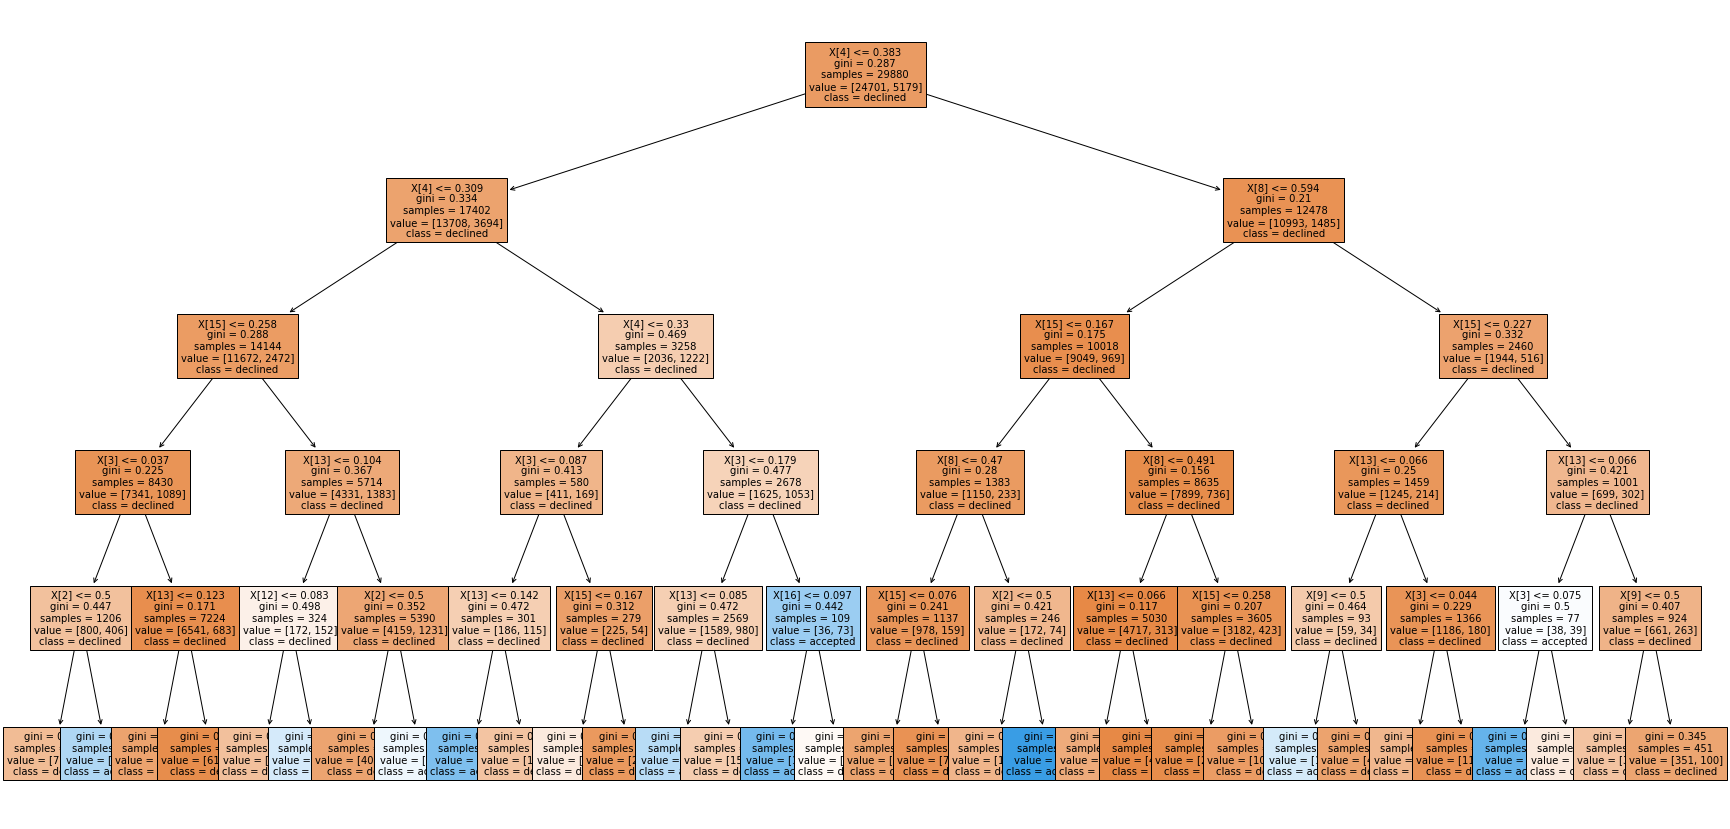

In [31]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(30, 15))
clf = DecisionTreeClassifier(max_depth = 5, 
                             random_state = 0)
clf.fit(x_train, y_train)
cn=['declined', 'accepted']
tree.plot_tree(clf, fontsize=10, class_names=cn, filled=True)
plt.show()

## 7) Сравнение моделей

In [32]:
print('Логистическая регрессия')
print_metrics(y_test, y_pred_log)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Логистическая регрессия
Precision: 0.5862068965517241
F1-measure: 0.01446808510638298

Метод опорных векторов
Precision: 0.5714285714285714
F1-measure: 0.003436426116838488

Дерево решений
Precision: 0.4374255065554231
F1-measure: 0.23227848101265824
